In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import math
import numpy as np
import statistics as stat
import scipy.stats as st
import itertools
import scipy.linalg as la

import warnings
warnings.filterwarnings("ignore")

#### Úvod
Z obou datových souborů načtěte texty k analýze. Pro každý text zvlášť zjistěte absolutní četnosti jednotlivých znaků (symbolů včetně mezery), které se v textech vyskytují. Dále předpokládejme, že první text je vygenerován z homogenního markovského řetězce s diskrétním časem.

#### 1. Za předpokladu výše odhadněte matici přechodu markovského řetězce pro první text. Pro odhad matice přechodu vizte [přednášku 17](https://courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-17-Handout.pdf). Odhadnuté pravděpodobnosti přechodu vhodně graficky znázorněte, např. použitím heatmapy. (2b)

In [2]:
# nacteni dat
def read_file(file):
    with open(file) as f:
        lines = f.readlines()
        return lines[1]

dpath = Path('../data')
first = read_file(dpath / 'first-009.txt')
second = read_file(dpath / 'second-005.txt')

In [3]:
# vypocitani cetnosti
def check_freq(x):
    freq = {}
    for c in set(x):
        freq[c] = x.count(c)
    return freq

freq_first = check_freq(first)
freq_second = check_freq(second)

col = ['znak', 'absolutni cetnost']
dfa = pd.DataFrame(freq_first.items(), columns=col)
dfb = pd.DataFrame(freq_second.items(), columns=col)

def comp_rel_freq(*arg):
    for df in arg:
        df['relativni cetnost'] = df['absolutni cetnost'] / df['absolutni cetnost'].sum()
        
comp_rel_freq(dfa, dfb)

# aplha sort
dfa = dfa.sort_values('znak').reset_index(drop=True)
dfb = dfb.sort_values('znak').reset_index(drop=True)
display(dfa.head())
display(dfb.head())

,znak,absolutni cetnost,relativni cetnost
0,,1059,0.189887
1,a,366,0.065627
2,b,65,0.011655
3,c,105,0.018827
4,d,205,0.036758


,znak,absolutni cetnost,relativni cetnost
0,,1079,0.199445
1,a,378,0.069871
2,b,64,0.011830
3,c,82,0.015157
4,d,218,0.040296


Pro odhad matice přechodu prvního textu budeme potřebovat definici $n_{ij}$ ze zmíněné přednášky: <div>
<img src="../img/transition-cnt.png" width="50%"/>
</div>
Interpretace $n_{ij}$ pro naše zadání je počet dvojic znaků $AB$ takových, že $A=i$ a $B=j$.

MLE odhad matice přechodu $\hat{\mathrm{P}}$ pak zkonstruujeme následovně:

<img src="../img/mle-transition-mtx.png" width="60%"/>
</div>

In [4]:
# inicializace matice \hat{P}
dfa_mtx = pd.DataFrame(0, index=list(dfa.znak), columns=list(dfa.znak))

# pocitani dvojic AB v prvnim textu & vyplneni matice \hat{P}
# pozor na spravne CAM indexovani, aby sedela definice n_ij
# [B][A] je pocet prechodu z A do B
for i, c in enumerate(first[:-1]):
    dfa_mtx[first[i+1]][c] += 1

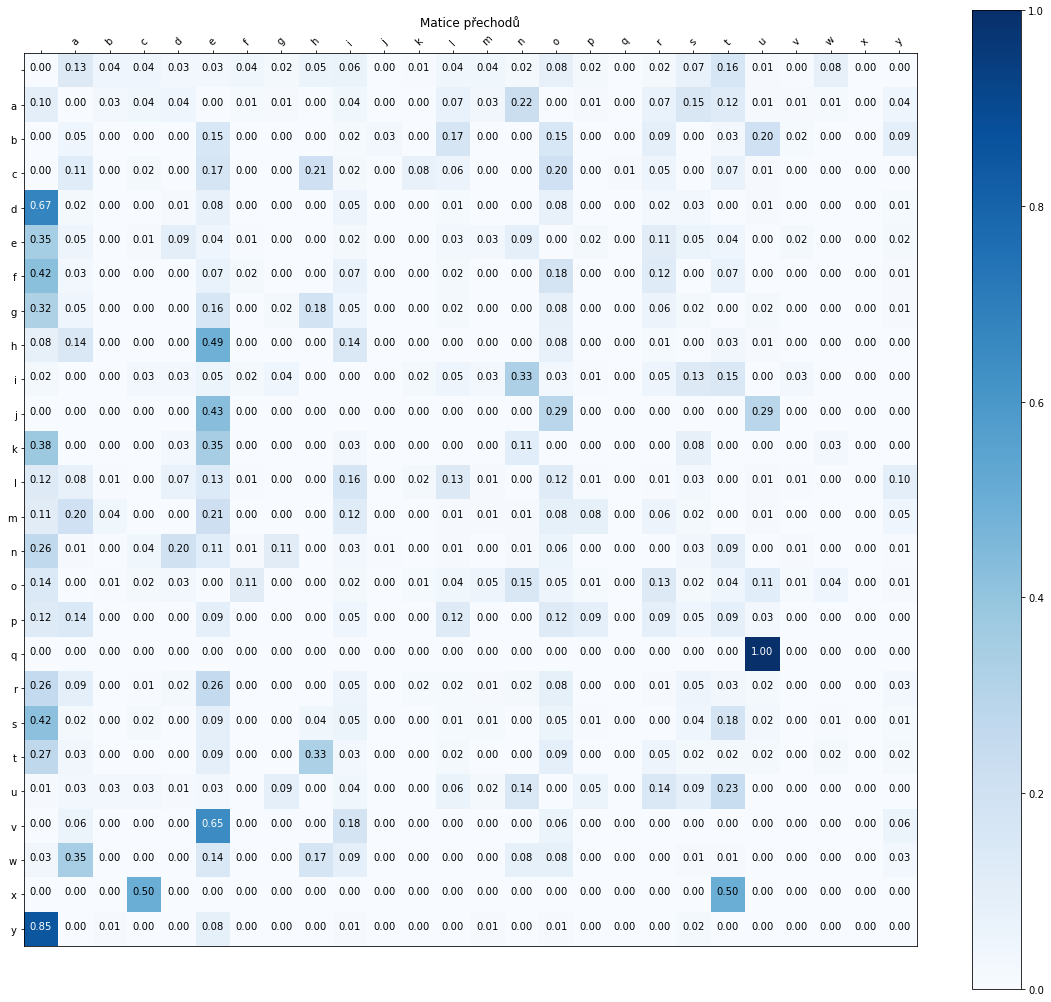

In [5]:
# heatmapa (vykreslovani je prevzato z domaciho ukolu z NI-PDD)
# modified and taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matice přechodů',
                          cmap=plt.cm.Blues,
                          figsize=(20, 20)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        s = cm.sum(axis=1)[:, np.newaxis]
    
        cm = cm.astype('float') / s

    plt.rc('figure', figsize=figsize)
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
    plt.show()
    return cm

P = plot_confusion_matrix(cm=np.array(dfa_mtx),
                      classes=dfa.znak,
                      normalize=True,
                      figsize=(20,18))

#### 2. Na základě matice z předchozího bodu najděte stacionární rozdělení π tohoto řetězce pro první text. (2b)

V této části budeme vycházet z následující definice:

<img src="../img/def_stac_rozdeleni.png" width="60%"/>

Zdroj: <a href="https://courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-14-Handout.pdf">NI-VSM-Lec-14-Handout</a>, strana 10

A **důsledku 13.30**: _Je-li množina stavů S konečná, pak stacionární rozdělení existuje_

Zdroj: <a href="https://courses.fit.cvut.cz/NI-VSM/@master/lectures/files/NI-VSM-Lec-15-Handout.pdf">NI-VSM-Lec-15-Handout</a>, strana 11

#### Víme, že v našem případě tedy stacionární rozdělení určitě existuje a pro stacionární rozdělení  $\pi$ musí platit:
    
$ \pi * P = \pi \Leftrightarrow \pi * P - \pi = 0 \Leftrightarrow \pi * (P - I) = 0 $

Hodnotu $\pi$ následně vypočítáme pomocí metody <a href='https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.null_space.html'>_scipy.linalg.null_space_</a>, která najde vektor $\pi$ splňující tuto homogenní rovnici.

Tento vektor následně znormalizujeme a tím dostaneme hledané stacionární rozdělení.

In [6]:
# výpočet stacionárního rozdělení z matice P
def StacDist(P):
    W = np.transpose(P-np.eye(P.shape[0]))
    pi = la.null_space(W)
    pi = np.transpose(pi/sum(pi))
    return pi[0]

In [7]:
pi_a = StacDist(P)
print('Stacionární rozdělení prvního textu:\n', pi_a)

Stacionární rozdělení prvního textu:
 [0.18992178 0.06564261 0.01165712 0.01882937 0.03678322 0.10060166
 0.0182931  0.01560396 0.04948341 0.05002972 0.00125545 0.00663557
 0.03479484 0.01955051 0.06170504 0.06401591 0.01165869 0.0014353
 0.0466452  0.05075576 0.08014038 0.01990225 0.0061002  0.02116084
 0.00035929 0.01703882]


Můžeme ověřit vlastnosti _(i)_ a _(ii)_
* _(i)_ - z zobrazených hodnot výše je možné vidět, že všechny členy $\pi$ jsou $\geq 0$
* _(ii)_ - součet všech hodnot by měl být (vzhledem k tomu, že jsme vektor normalizovali) roven 1. Níže tuto vlastnost ověříme.

In [8]:
print('Je součet členů stacionárního rozdělení roven 1?', np.sum(StacDist(P)) == 1)

Je součet členů stacionárního rozdělení roven 1? True


#### 3. Porovnejte rozdělení znaků druhého textu se stacionárním rozdělením π, tj. na hladině významnosti 5 % otestujte hypotézu, že rozdělení znaků druhého testu se rovná rozdělení π z předchozího bodu. (2b)

Využijeme absolutni četnosti znaků druhého textu, které máme již předpočítané v proměnné `dfb`. Označme si toto rozdělení znaku jako **p'**.

Hypotézu můžeme po bližším prozkoumání množin znaků obou rozdělení rovnou zamítnout. Stacionární rozdělení  $\pi$ totiž neobsahuje všechny znaky, které jsou obsaženy v druhém textu. Konkrétně se jedná o znak `z`. Navíc, protože `z` není pouze počáteční písmeno textu (a zároveň do něj nevede cesta pouze z přechodných stavů), nejedná se o přechodný stav, ale trvalý a tudíž ve stacionárním rozdělení pro druhý text musí být pravděpodobnost přechodu do stavu `z` > 0, což už je ovšem v rozporu se stacionárním rozdělení π.

Abychom mohli i přesto otestovat alespoň nějakou hypotézu, odstraníme z druhého textu písmeno `z` a nebudeme s ním nadále operovat.

In [9]:
print(f"Znaky, ktere neobsahuje stacionarni rozdeleni: {set(dfb.znak).difference(set(dfa.znak))}")

Ni = np.array(dfb[dfb.znak != 'z']['absolutni cetnost'])
n = np.sum(Ni)

print(f"Rozdeleni znaku druheho textu (bez z):\n {Ni}")
print(f"Pocet znaku druheho textu (bez z): {n}\n")

Znaky, ktere neobsahuje stacionarni rozdeleni: {'z'}
Rozdeleni znaku druheho textu (bez z):
 [1079  378   64   82  218  542   91   97  275  314    3   44  177  151
  270  298   76    4  273  249  383   98   44   90    6  101]
Pocet znaku druheho textu (bez z): 5407



Z předchozího bodu máme definované stacionární rozdělení $\pi$. To se dá interpretovat jako náhodný výběr s vypočítanými teoretickými četnostmi s pomocí homogenního markovského řetězce. Náš úkol je porovnat toto rozdělení s rozdělením znaků z druhého textu. To je náš náhodný výběr znaků. Na to se dá použít $\chi^{2}$ testu dobré shody při známých parametrech.

K otestování, zda se rozdělení znaků druhého textu **p'** rovná stacionárnímu rozdělení $\pi$ z předchozího bodu, tedy použijeme $\chi^{2}$ test dobré shody při známých parametrech.
Hypotézu tak sestavíme následovně:
* $H_0: p' = \pi$ (rozdělení znaků druhého textu se rovná rozdělení $\pi$),
* $H_A: p' \neq \pi$ (nerovná se).

Nejprve si ovšem musíme ověřit podmínky, zda bude test průkazný. Zvolíme si "volnější" kritérium a to Yarnoldovo.

<img src="../img/chi_square_test.png" width="50%"/>

(převzato z prezentace 12, slide 5)


In [10]:
npi = pi_a*n
print(f"Teoreticke cetnosti stacionarniho rozdeleni:\n {npi}\n")
print(f"Splnuje chi-kvadrat test podminky Yarnoldova kriteria? => {not(npi < (5*(len(npi)-sum(npi < 5))/len(npi))).any()}")

Teoreticke cetnosti stacionarniho rozdeleni:
 [1026.90706519  354.92958068   63.03004863  101.81041308  198.88685079
  543.95316084   98.91081036   84.37060913  267.55680081  270.51071988
    6.78823366   35.87855013  188.13567492  105.70961451  333.63912842
  346.13401634   63.0385357     7.76065614  252.21061661  274.43638154
  433.31903134  107.61147718   32.98376931  114.41668588    1.94268986
   92.12887907]

Splnuje chi-kvadrat test podminky Yarnoldova kriteria? => False


Jak můžeme vidět, není splněno Yarnoldovo kritérium, konkrétně pro znak `x`. Nabízejí se zde proto následující možnosti:
* Sloučení znaků tak, aby bylo Yarnoldovo kritérium splněno. Tímto způsobem ovšem momentálně nemůžeme postupovat, nedává smysl slučovat znaky ze dvou důvodů. První je, že slučování znaků je slučování stavů v markovském řetězci. V takovém případě by se muselo celé stacionární rozdělení přepočítat a mohlo by vypadat naprosto rozdílně. Druhým je, že máme pevně definované stacionární rozdělení a slučování znaků by znamenalo odchýlení se od zadání a tudíž jeho nesplnění. Vhodnější možností, jak v tomto případě postupovat a postup, který jsme zvolili, je druhý bod.
* Použít $\chi^{2}$ test dobré shody při známých parametrech s připuštením možnosti neprůkazného výsledku zaviněným nedostatečnými teoretickými četnostmi daných znaků.

In [11]:
stat, p_val = st.chisquare(Ni,npi)
alpha = .05
print(f'Zamitame hypotezu H0 na hladine vyznamnosti alpha={alpha}? => {p_val <= alpha}')
print(f'p-val: {p_val}')

Zamitame hypotezu H0 na hladine vyznamnosti alpha=0.05? => True
p-val: 3.0436395490419854e-10


Z $\chi^{2}$ test nám určil p-hodnotu podstatně nižší než jsme si určili hladinu významnosti.
**Zamítáme proto hypotézu $H_0: p = \pi$ (rozdělení znaků druhého textu se rovná rozdělení $\pi$) ve prospěch $H_A: p \neq \pi$ (nerovná se).**

V potaz samozřejmě musíme vzít fakt, že:
- a) Rozdělení druhého textu obsahuje proti stacionárnímu rozdělení $\pi$ znak `z` navíc, museli jsme se proto omezit na podmnožinu znaků.
- b) Není splněno Yarnoldovo kritérium (pro znak `x`), test nemusí být dostatečně průkazný. Pro splnění kritéria by byl potřeba větší rozsah n (tzn. vyšší počet nezávislých výběrů)
